## Groundwater Whirls with PRT

This is a 10 layer steady-state problem involving anisotropic groundwater
flow.  The XT3D formulation is used to represent variable hydraulic
conductivitity ellipsoid orientations.  The resulting flow pattern consists
of groundwater whirls, as described in the XT3D documentation report. A
particle tracking model is created to visualize the whirls.

### Initial setup

Import dependencies and define the example name and workspace.

In [1]:
import pathlib as pl
from itertools import repeat
import warnings

import flopy
import pandas as pd
import numpy as np
import pyvista as pv
from flopy.export.vtk import Vtk

warnings.simplefilter("ignore", UserWarning)

sim_name = "whirls-prt"
gwf_name = sim_name + "-gwf"
prt_name = sim_name + "-prt"
workspace = pl.Path("xt3d-prt")
sim_ws = workspace / sim_name

# Define output file names
headfile_gwf = f"{gwf_name}.hds"
budgetfile_gwf = f"{gwf_name}.cbb"
budgetfile_prt = f"{prt_name}.cbb"
trackfile_prt = f"{prt_name}.trk"
trackhdrfile_prt = f"{prt_name}.trk.hdr"
trackcsvfile_prt = f"{prt_name}.trk.csv"


### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 1  # Number of periods
nlay = 10  # Number of layers
nrow = 10  # Number of rows
ncol = 51  # Number of columns
delr = 100.0  # Spacing along rows ($m$)
delc = 100.0  # Spacing along columns ($m$)
top = 0.0  # Top of the model ($m$)
botm_str = "-100, -200, -300, -400, -500, -600, -700, -800, -900, -1000"  # Layer bottom elevations ($m$)
strt = 0.0  # Starting head ($m$)
icelltype = 0  # Cell conversion type
k11 = 1.0  # Hydraulic conductivity in the 11 direction ($m/d$)
k22 = 0.1  # Hydraulic conductivity in the 22 direction ($m/d$)
k33 = 1.0  # Hydraulic conductivity in the 33 direction ($m/d$)
angle1_str = "45, 45, 45, 45, 45, -45, -45, -45, -45, -45"  # Rotation of the hydraulic conductivity ellipsoid in the x-y plane
inflow_rate = 0.01  # Inflow rate ($m^3/d$)

# Static temporal data used by TDIS file
# Simulation has 1 steady stress period (1 day)
perlen = [1.0]
nstp = [1]
tsmult = [1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))

# Parse strings into lists
botm = [float(value) for value in botm_str.split(",")]
angle1 = [float(value) for value in angle1_str.split(",")]

# Solver settings
nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6

### Model setup

Next we build models. In this example the groundwater flow (GWF) and particle tracking (PRT) model run within the same simulation.

In [3]:
sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")

flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)

gwf = flopy.mf6.ModflowGwf(sim, modelname=gwf_name, save_flows=True)

ims = flopy.mf6.ModflowIms(
    sim,
    linear_acceleration="bicgstab",
    outer_maximum=nouter,
    outer_dvclose=hclose,
    inner_maximum=ninner,
    inner_dvclose=hclose,
    rcloserecord=f"{rclose} strict",
)
sim.register_solution_package(ims, [gwf.name])

flopy.mf6.ModflowGwfdis(
    gwf,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

flopy.mf6.ModflowGwfnpf(
    gwf,
    icelltype=icelltype,
    k=k11,
    k22=k22,
    k33=k33,
    angle1=angle1,
    save_specific_discharge=True,
    save_saturation=True,
    save_flows=True,
    xt3doptions=True,
)
flopy.mf6.ModflowGwfic(gwf, strt=strt)

rate = np.zeros((nlay, nrow, ncol), dtype=float)
rate[:, :, 0] = inflow_rate
rate[:, :, -1] = -inflow_rate
wellay, welrow, welcol = np.where(rate != 0.0)
wel_spd = [((k, i, j), rate[k, i, j], 1 if rate[k, i, j] > 0 else 3) for k, i, j in zip(wellay, welrow, welcol)]
wel_spd = {0: wel_spd}
flopy.mf6.ModflowGwfwel(
    gwf,
    stress_period_data=wel_spd,
    pname="WEL",
    auxiliary=["IFLOWFACE"]
)

flopy.mf6.ModflowGwfoc(
    gwf,
    head_filerecord=[headfile_gwf],
    budget_filerecord=[budgetfile_gwf],
    saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
)

prt = flopy.mf6.ModflowPrt(
    sim, modelname=prt_name, model_nam_file="{}.nam".format(prt_name)
)

flopy.mf6.ModflowGwfdis(
    prt,
    length_units=length_units,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
)

flopy.mf6.ModflowPrtmip(prt, pname="mip", porosity=0.1)

xs = np.array(list(repeat(50, 4)))
ys = np.linspace(1, 999, 4)
zs = np.linspace(1, 999, 4) * -1
points = np.transpose(np.array(np.meshgrid(xs, ys, zs)).reshape(3, -1))
releasepts = [
    (i, *prt.modelgrid.intersect(*p), *p) for i, p in enumerate(points)
]
flopy.mf6.ModflowPrtprp(
    prt,
    nreleasepts=len(releasepts),
    packagedata=releasepts,
    perioddata={0: ["FIRST"]},
    exit_solve_tolerance=1e-5,
    istopzone=2
)

flopy.mf6.ModflowPrtoc(
    prt,
    pname="oc",
    budget_filerecord=[budgetfile_prt],
    track_filerecord=[trackfile_prt],
    trackcsv_filerecord=[trackcsvfile_prt],
    saverecord=[("BUDGET", "ALL")],
)

flopy.mf6.ModflowGwfprt(sim, exgtype="GWF6-PRT6", exgmnamea=gwf_name, exgmnameb=prt_name)

ems = flopy.mf6.ModflowEms(
    sim,
    pname="ems",
    filename="{}.ems".format(prt_name),
)
sim.register_solution_package(ems, [prt.name])

### Run models

We are ready to run the models. First write model input files, then run the simulation.

In [4]:

# Write and run the simulation.
sim.write_simulation(silent=False)
success, buff = sim.run_simulation(silent=False)


writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing solution package ems...
  writing package whirls-prt.gwfprt...
  writing model whirls-prt-gwf...
    writing model name file...
    writing package dis...
    writing package npf...
    writing package ic...
    writing package wel...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 200 based on size of stress_period_data
    writing package oc...
  writing model whirls-prt-prt...
    writing model name file...
    writing package dis...
    writing package mip...
    writing package prp_0...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../micromamba/envs/mfandmore2024/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled May 23 2024 18:02:47

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/05/30 21:59:34
 Elapsed run time:  0.152 Seconds
 
 Normal termination of simulation.


### Inspect results

We can now load and plot model results. Below we use [PyVista](https://docs.pyvista.org/version/stable/) to create 3D visualizations.

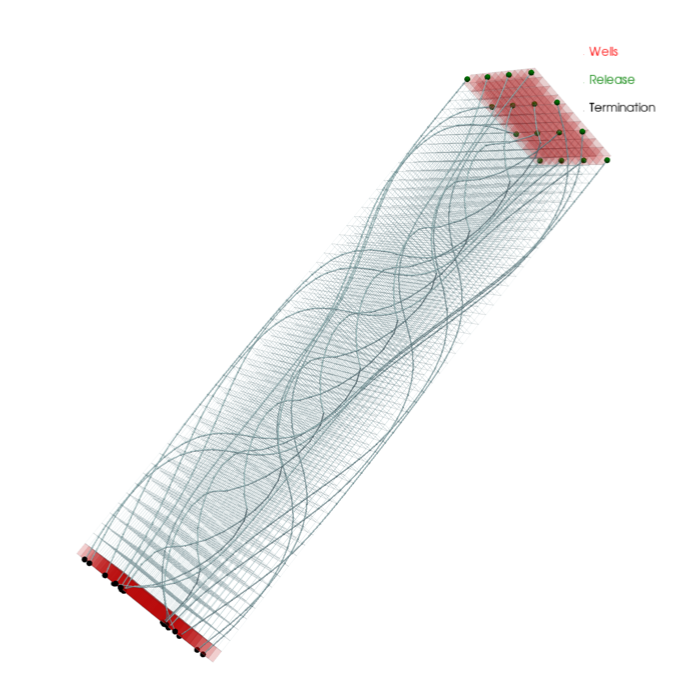

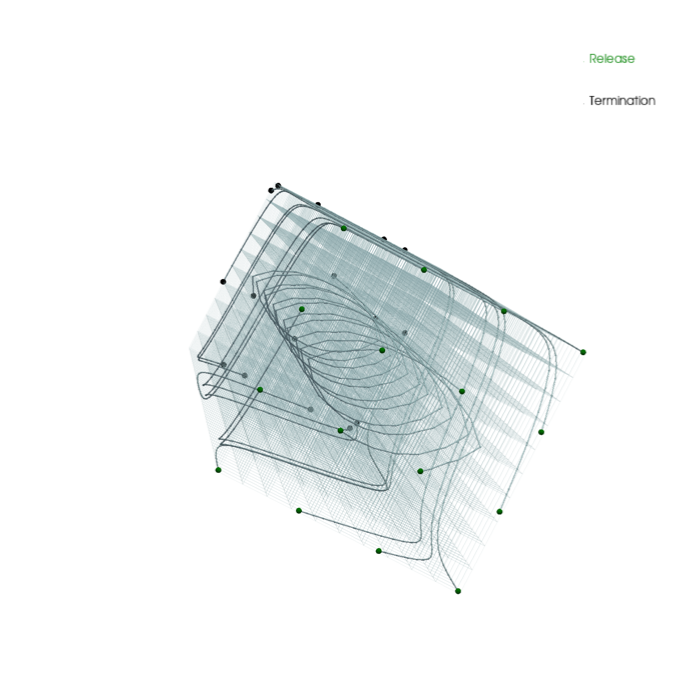

In [5]:

pv.set_jupyter_backend("static")

pls = pd.read_csv(sim_ws / trackcsvfile_prt)
gwf = sim.get_model(gwf_name)
pv.set_plot_theme("document")
axes = pv.Axes(show_actor=False, actor_scale=2.0, line_width=5)
vtk = Vtk(model=gwf, binary=False, vertical_exageration=1, smooth=False)
vtk.add_model(gwf)
vtk.add_pathline_points(pls)
gwf_mesh, prt_mesh = vtk.to_pyvista()
wel_nodes = gwf.modelgrid.get_node([w[0] for w in wel_spd[0]])
wel_mesh = gwf_mesh.remove_cells(
    list(set(range(gwf.modelgrid.nnodes)) - set(wel_nodes)), inplace=False
)
rel_mesh = pv.wrap(pls[pls.ireason == 0][["x", "y", "z"]].to_numpy())
ter_mesh = pv.wrap(pls[pls.ireason == 3][["x", "y", "z"]].to_numpy())


def rotate(xrot=0, yrot=0, zrot=0):
    meshes = [gwf_mesh, prt_mesh, wel_mesh, rel_mesh, ter_mesh]
    for mesh in meshes:
        mesh.rotate_x(xrot, point=axes.origin, inplace=True)
        mesh.rotate_y(yrot, point=axes.origin, inplace=True)
        mesh.rotate_z(zrot, point=axes.origin, inplace=True)


def plot_3d(xrot=0, yrot=0, zrot=0, zoom=1, wel_alpha=0.1):
    p = pv.Plotter(
        window_size=[700, 700],
    )
    p.enable_anti_aliasing()
    rotate(xrot, yrot, zrot)
    p.add_mesh(
        gwf_mesh,
        opacity=0.1,
        style="wireframe",
    )
    if wel_alpha > 0:
        p.add_mesh(
            wel_mesh,
            opacity=wel_alpha,
            color="red",
            label="Wells"
        )
    p.add_mesh(
        prt_mesh,
        opacity=0.3,
        point_size=4,
        line_width=3,
        render_points_as_spheres=True,
        render_lines_as_tubes=True,
        smooth_shading=True,
    )
    p.add_mesh(
        rel_mesh,
        color="green",
        point_size=13,
        render_points_as_spheres=True,
        label="Release"
    )
    p.add_mesh(
        ter_mesh,
        color="black",
        point_size=13,
        render_points_as_spheres=True,
        label="Termination"
    )
    p.add_legend(face=None, bcolor=None, size=(0.13, 0.13))
    p.camera.zoom(zoom)
    p.show()

# Create a 3D plot from a lateral perspective.
plot_3d(xrot=30, yrot=30, zoom=1.2)

# Create a 3D plot from a frontal perspective.
plot_3d(xrot=0, yrot=120, zrot=50, zoom=2.2, wel_alpha=0)